In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


In [3]:
rc = {
    "axes.facecolor": "#F0FFF0",
    "figure.facecolor": "#F0FFF0",
    "axes.edgecolor": "#000000",
    "grid.color": "#228B22",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)

In [4]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

# PreProcessing

In [5]:
def preprocessing(df):
    
    df['Name'] =  df['Name'].map(lambda x : x.split(',')[1].split('.')[0].strip())
    

    common_name = ['Mr', 'Miss', 'Mrs', 'Master', 'Dr']
    
    name_changer = {}

    for name in df['Name'].unique():

        if name in common_name:

            name_changer[name] = name
        else:

            name_changer[name] = 'Rare'
            

    df['Name'] = df['Name'].map(name_changer)
    
    df = df.drop(['Ticket','Cabin','PassengerId'], axis = 1)
    
    for col in df.columns:
        
        if (df[col].dtype in (int,float)):

            if df[col].isna().sum() > 0:

                df[col] = df[col].fillna(df[col].median())
                
        else:
            
            if df[col].isna().sum() > 0:
                
                most_freq = df[col].value_counts().index[0]
                
                df[col] = df[col].fillna(most_freq)
                
                
    df['Family_size'] = df['SibSp'] + df['Parch'] + 1

    df.drop(['SibSp','Parch'],axis = 1)

    df['Pclass'] = df['Pclass'].astype(str)

    df = df.drop(['SibSp','Parch'], axis = 1)

    return pd.get_dummies(df)

In [6]:
df = preprocessing(train)

# EDA 

In [7]:
def pca_3d_scatter(df):
    
    X = df.iloc[:,1:]

    pca = PCA(n_components = 3)

    pca_x = pca.fit_transform(X)

    X_pca = pd.DataFrame(pca_x)

    X_pca['target'] = df.iloc[:,0]
    
    cmap = {0 : 'red', 1 : 'blue'}

    colors = X_pca['target'].map(cmap)
    
    fig,ax = plt.subplots(ncols = 3,
                     subplot_kw ={'projection': '3d'},
                      figsize = (15,5))

    view = [15,45,90]

    for _ in range(3):

        ax[_].scatter(xs = X_pca[0],
                     ys = X_pca[1],
                     zs = X_pca[2],
                     color = colors,
                     alpha = 0.3)

        ax[_].view_init(45,view[_])

    fig.text(0.42, 0.95, '3D Scatterplot           &', ha='center', color='black', fontsize=14)
    fig.text(0.46, 0.95, 'Dead',color='red', fontsize= 14, ha = 'center')
    fig.text(0.53, 0.95, 'Survival',color = 'blue', fontsize = 14, ha = 'center')

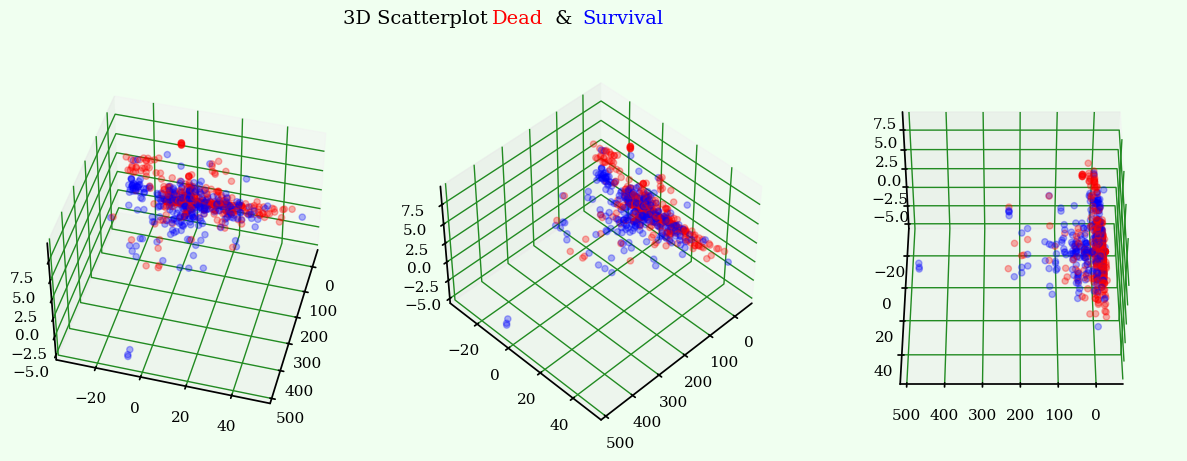

In [8]:
pca_3d_scatter(df)

# Modeling

In [9]:
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
def create_model(INPUT_SHAPE, LAYERS,FIRST_NODE,
               HIDDEN_NODE,L2, DROPOUT_RATE):

    inputs = layers.Input(shape = INPUT_SHAPE)
    x = layers.Dense(FIRST_NODE, activation = 'relu')(inputs)
    x = layers.BatchNormalization()(x)

    for _ in range(LAYERS):
        x = layers.Dense(HIDDEN_NODE, activation = 'relu',
                        kernel_regularizer=regularizers.L2())(x)
        x = layers.BatchNormalization()(x)    
        x = layers.Dropout(DROPOUT_RATE)(x)


    outputs = layers.Dense(1, activation = 'sigmoid')(x)

    model = keras.Model(inputs,outputs)
    
    return model

In [11]:
def cross_validation(N_SPLITS,
                    X,y,model_params, optimizers,THRESHOLD):
    
    early_stopping = EarlyStopping(monitor = 'val_accuracy', 
                              patience = 50)

    cv = KFold(n_splits = N_SPLITS,
              random_state = 42, shuffle = True)

    avg_score = 0

    for i,(train_idx, test_idx) in enumerate(cv.split(X,y)):

        x_train, x_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = create_model(**model_params)    
        model.compile(**optimizers)    

        model.fit(x_train,y_train,
                 validation_data = (x_test,y_test),
                 epochs = 9999,
                 callbacks = [early_stopping],
                 verbose = 0)

        predicted = (model.predict(x_test,verbose = 0) > THRESHOLD).astype(int)

        score = accuracy_score(y_test,predicted)

        print(f'{i} Fold set Accuracy :', round(score,3) * 100, '%')

        avg_score += score / 5

    print('AVG accuracy: ', round(avg_score,3) * 100 )

# Simple Model & Less Regularizes 
### vs
# Complex Model & More Regularizes

In [12]:
X = df.iloc[:,1:]
y = df.iloc[:,0]

In [13]:
simple_params = {'INPUT_SHAPE' : X.shape[1:],
                'LAYERS' : 3,
                'FIRST_NODE' : 16,
                'HIDDEN_NODE' : 16,
                'L2':.001,
                'DROPOUT_RATE':.01}

complex_params = {'INPUT_SHAPE' : X.shape[1:],
                'LAYERS' : 5,
                'FIRST_NODE' : 128,
                'HIDDEN_NODE' : 64,
                'L2':.01,
                'DROPOUT_RATE':.3} 
    
optimizers = {'loss':'binary_crossentropy',
         'optimizer':tf.optimizers.legacy.Adam(learning_rate = 0.01),
         'metrics':'accuracy'}   

THRESHOLD = 0.5

# Simple Model & Less Regularizes 

In [14]:
cross_validation(5,X,y,simple_params,optimizers,0.5)

0 Fold set Accuracy : 81.6 %
1 Fold set Accuracy : 79.80000000000001 %
2 Fold set Accuracy : 87.1 %
3 Fold set Accuracy : 79.80000000000001 %
4 Fold set Accuracy : 84.3 %
AVG accuracy:  82.5


# Complex Model & More Regularizes

In [15]:
cross_validation(5,X,y,complex_params,optimizers,0.5)

0 Fold set Accuracy : 81.6 %
1 Fold set Accuracy : 80.9 %
2 Fold set Accuracy : 85.39999999999999 %
3 Fold set Accuracy : 78.10000000000001 %
4 Fold set Accuracy : 80.30000000000001 %
AVG accuracy:  81.3


# Training history

In [16]:
X = df.iloc[:,1:]
y = df[['Survived']]

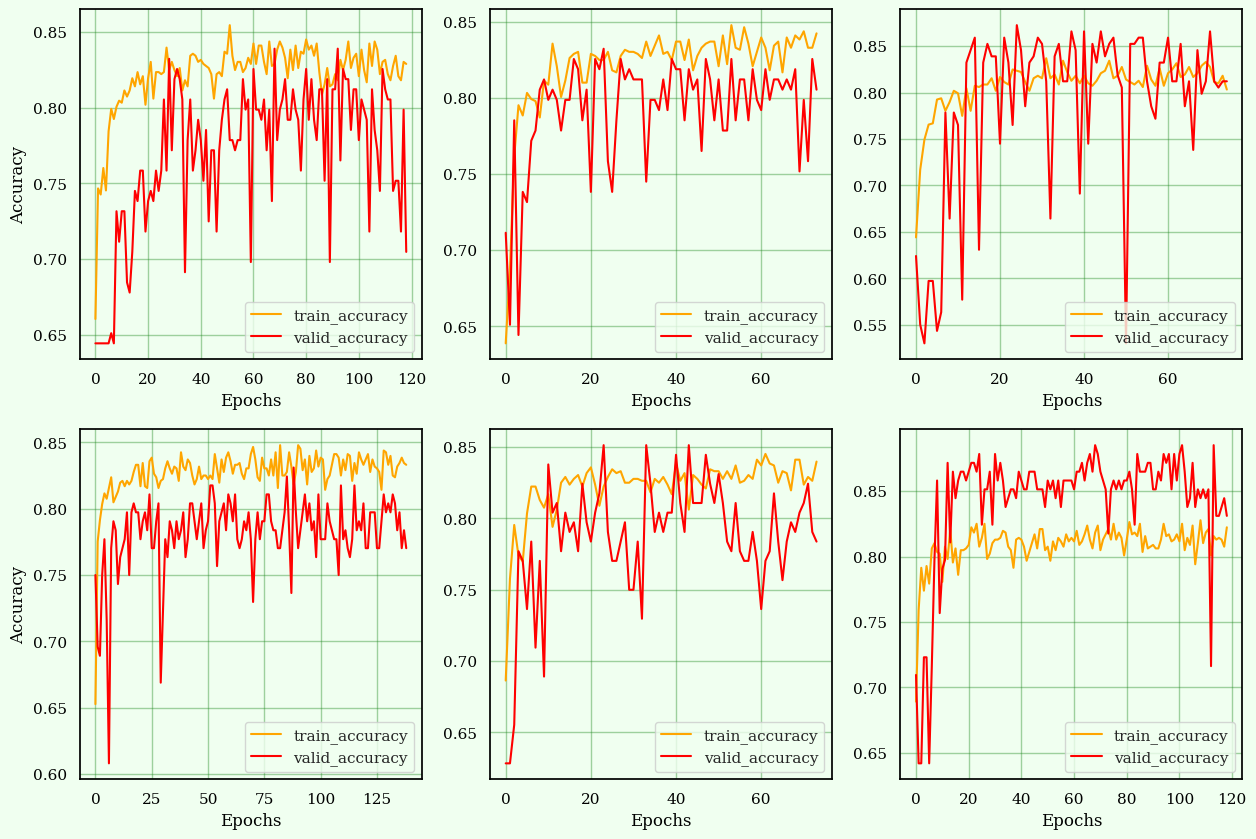

In [17]:
cv = KFold(n_splits = 6)

early_stopping = EarlyStopping(monitor = 'val_accuracy', 
                          patience = 50)

fig, ax = plt.subplots(nrows = 2, ncols = 3,
                      figsize = (15,10))

ax = ax.flatten()


for i, (train_idx,test_idx) in enumerate(cv.split(X,y)):
    
    train_x, valid_x = X.iloc[train_idx], X.iloc[test_idx]
    train_y, valid_y = y.iloc[train_idx], y.iloc[test_idx]
    
    model = create_model(** simple_params)

    model.compile(**optimizers)

    history = model.fit(train_x,train_y,
                     validation_data = (valid_x,valid_y),
                     callbacks = [early_stopping],
                     epochs = 9999,
                     verbose = 0)
    
    ax[i].plot(history.history['accuracy'], label = 'train_accuracy', c = 'orange')
    ax[i].plot(history.history['val_accuracy'], label = 'valid_accuracy', c = 'red')
    
    ax[i].legend(loc = 'lower right')
    ax[i].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[3].set_ylabel('Accuracy')

# ROC Curve

In [18]:
simple_model = create_model(** simple_params)

simple_model.compile(**optimizers)

In [19]:
complex_model = create_model(** simple_params)

complex_model.compile(**optimizers)

In [20]:
x_train,x_test,y_train,y_test = train_test_split(X,y, test_size = 0.2, stratify = y)

6/6 [==============================] - 0s 4ms/step


Text(0.5, 1.0, 'ROC curve')

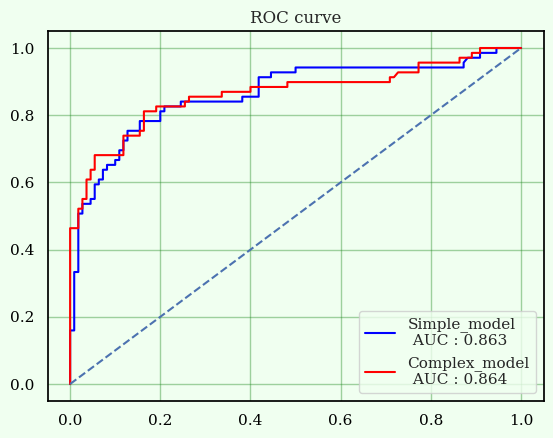

In [21]:
from sklearn.metrics import roc_curve, auc


models = [simple_model,complex_model]
names = ['Simple_model','Complex_model']
color = ['blue','red']

for i,model in enumerate(models):
    
    model = model
    
    model.fit(x_train,y_train,
             epochs = 100,
             verbose = 0)
    
    proba = model.predict(x_test)
    
    fpr,tpr,_ = roc_curve(y_test,proba)
    
    AUC = round(auc(fpr,tpr),3)
    
    plt.plot(fpr,tpr,label = f'{names[i]}\n AUC : {AUC}', c = color[i])
    
    
plt.plot([0,1],[0,1], ls = '--')
plt.legend(loc = 'lower right')
plt.title('ROC curve')    

In [22]:
test = preprocessing(test)

In [23]:
complex_model = create_model(** simple_params)

complex_model.compile(**optimizers)

complex_model.fit(X,y,epochs = 100,verbose = 0)

In [24]:
sub = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

In [25]:
sub['Survived'] = (complex_model.predict(test) > 0.5).astype(int)

14/14 [==============================] - 0s 2ms/step


In [26]:
sub.to_csv('complex.csv',index = False)

In [27]:
sub

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
